# Import Packages and Data set

In [4]:
# EDA - Data Cleaning
import pandas as pd
import numpy as np
import missingno
from collections import Counter
import math

# EDA - Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

#Modeling
from sklearn import (datasets,
                     metrics,
                     model_selection as skms,
                     naive_bayes,
                     neighbors)

from sklearn.linear_model import (LogisticRegression)

from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     train_test_split,
                                     GridSearchCV)
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             confusion_matrix,
                             f1_score,
                             roc_curve,
                             auc,
                             classification_report,
                             precision_recall_curve)

from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# logistic regression model
import statsmodels.api as sm 

pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.2f}'.format

# Define Functions

In [5]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("Initial Accuracy Score:  {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))),'-'*40)
            
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n") 
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test)))) 
        print("Initial Accuracy Score:  {0:.4f}".format(accuracy_score(y_test, clf.predict(X_test))))

# Import Dataset

In [6]:
df = pd.read_csv('../01_data/02_modified/capstone_modeling.csv', index_col='gvkey')

# Review Dependant Variable Split (DV)

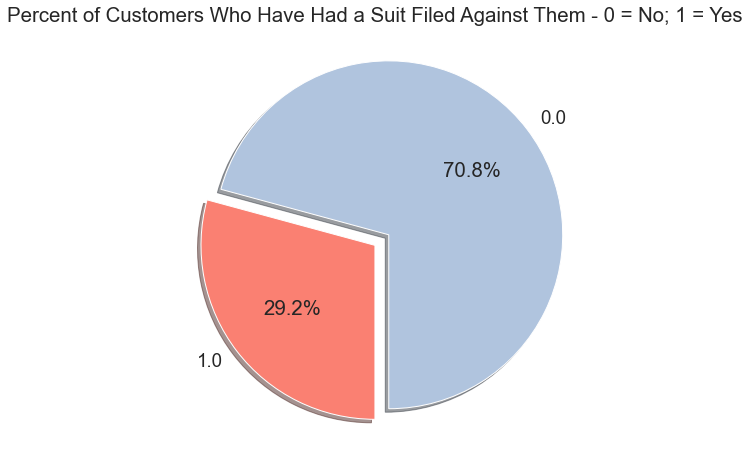

In [7]:
# Data to plot for the % of target variable
sns.set(font_scale = 1.7)
labels =df['suitflag'].value_counts(sort = True).index
sizes = df['suitflag'].value_counts(sort = True)
colors = ["lightsteelblue","salmon"]
explode = (0.1,0)  # explode 1st slice
 
rcParams['figure.figsize'] = 8,8
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Percent of Customers Who Have Had a Suit Filed Against Them - 0 = No; 1 = Yes')
plt.show()

# Logistic Regression - Initial Run

## Generate Dummy Variables

In [8]:
# df.to_csv('Sample_Used.csv', index=False)

In [9]:
cols = ['stko', 'restatementflag']

for ea in range(len(cols)):
    df[cols[ea]] = df[cols[ea]].astype(str)

In [10]:
binary_cols=[]
multi_Value=[]
for col in df.columns:
    if df[col].dtype =='object':
        if df[col].unique().shape[0]==2:
            binary_cols.append(col)
        else:
            multi_Value.append(col)
            
print('Multi-value columns include: ',multi_Value)
print('Binary-value columns include: ',binary_cols)

Multi-value columns include:  ['GIC_Industry', 'GIC_SubIndustry', 'stko']
Binary-value columns include:  ['idbflag', 'restatementflag']


In [11]:
for col in df.dtypes[df.dtypes == object].index:
    print(col,'\n', df[col].unique())

GIC_Industry 
 ['Aeorspace & Defense' 'Industrial Congolomerates' 'Machinery'
 'Electrical Equipment' 'Construction & Engineering']
GIC_SubIndustry 
 ['Aerospace & Defense' 'Industrial Conglomerates'
 'Construction & Farm Machinery & Heavy Trucks'
 'Electrical Components & Equipment' 'Industrial Machinary'
 'Heavy Electrical Equipment' 'Construction & Engineering'
 'Agricultural & Farm Machinery']
idbflag 
 ['D' 'B']
stko 
 ['0' '3' '2']
restatementflag 
 ['1' '0']


In [12]:
# Convert IDBflag, with Foreign_and_Domestic_indicator (1 = yes; 0 = no)
df['Foreign_and_Domestic_indicator'] = df['idbflag'].replace({'D':0, 'B':1})
df.drop(columns='idbflag', inplace=True)

In [13]:
GIC_Industry = pd.get_dummies(df['GIC_Industry'], prefix='GIC_Industry').drop(columns=['GIC_Industry_Industrial Congolomerates'])
df1 = df.join(GIC_Industry)

GIC_SubIndustry = pd.get_dummies(df['GIC_SubIndustry'], prefix='GIC_SubIndustry').drop(columns=['GIC_SubIndustry_Industrial Conglomerates'])
df1 = df1.join(GIC_SubIndustry)

stko = pd.get_dummies(df['stko'], prefix='stko').drop(columns=['stko_0'])
df1 = df1.join(stko)

In [14]:
df1.head(3).T

gvkey,10519,10622,10735
GIC_Industry,Aeorspace & Defense,Industrial Congolomerates,Machinery
GIC_SubIndustry,Aerospace & Defense,Industrial Conglomerates,Construction & Farm Machinery & Heavy Trucks
suitflag,1.00,1.00,1.00
stko,0,3,0
restatementflag,1,0,1
Vol_roe_Variance,0.06,0.06,0.06
Vol_capx_Variance,0.09,0.09,0.08
Vol_cogs_Variance,0.16,0.16,0.13
Vol_cshfd_Variance,0.07,0.07,0.07
Vol_dltt_Variance,0.12,0.08,0.11


In [15]:
#Dropping columns due to dummy variable additions
df2 = df1.drop(columns=['GIC_Industry', 
                        'GIC_SubIndustry', 
                        'stko'
                       ])

In [16]:
df2

,suitflag,restatementflag,Vol_roe_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,STD_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,STD_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,Foreign_and_Domestic_indicator,GIC_Industry_Aeorspace & Defense,GIC_Industry_Construction & Engineering,GIC_Industry_Electrical Equipment,GIC_Industry_Machinery,GIC_SubIndustry_Aerospace & Defense,GIC_SubIndustry_Agricultural & Farm Machinery,GIC_SubIndustry_Construction & Engineering,GIC_SubIndustry_Construction & Farm Machinery & Heavy Trucks,GIC_SubIndustry_Electrical Components & Equipment,GIC_SubIndustry_Heavy Electrical Equipment,GIC_SubIndustry_Industrial Machinary,stko_2,stko_3
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10519,1.00,1,0.06,0.09,0.16,0.07,0.12,0.08,1.73,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.10,0.26,0.34,0.04,0.42,0.16,0.26,0.11,0.49,0.26,0.30,0.46,0.30,0.36,0.16,0.09,0.23,0.12,0.19,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10622,1.00,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,1.07,2.38,3.00,0.53,0.23,3.00,0.57,0.00,2.52,2.61,3.00,1.12,0.70,1.51,0.28,0.02,3.00,0.13,0.19,1,0,0,0,0,0,0,0,0,0,0,0,0,1
10735,1.00,1,0.06,0.08,0.13,0.07,0.11,0.07,0.81,0.07,0.14,0.09,0.07,0.09,0.12,0.14,0.08,0.09,0.06,0.02,0.85,0.33,0.33,0.02,0.12,0.81,0.25,0.13,1.04,0.42,0.09,0.10,0.36,0.19,0.09,0.06,0.12,0.19,0,0,0,0,1,0,0,0,1,0,0,0,0,0
110685,1.00,1,0.06,0.08,2.47,0.07,0.08,0.06,3.00,0.07,0.14,0.10,1.40,0.10,0.69,0.53,0.05,0.01,0.06,0.05,0.15,0.88,0.03,0.03,0.04,1.93,0.30,0.02,0.08,0.89,0.31,0.19,0.35,0.07,0.10,0.19,0.13,0.20,0,1,0,0,0,1,0,0,0,0,0,0,0,0
113530,1.00,1,0.11,0.08,0.14,0.11,0.08,0.08,0.33,0.07,0.21,0.09,0.02,0.07,0.16,0.05,0.08,0.09,0.38,0.20,0.21,0.33,0.04,0.16,0.30,0.37,0.49,0.34,0.34,0.35,0.31,0.22,0.31,0.16,0.11,0.25,0.08,0.05,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,0.00,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.58,0.06,0.96,0.15,0.07,0.02,0.28,0.27,3.00,0.72,1.24,2.18,0.51,1.60,3.00,0.02,1.45,0.12,0.19,1,0,0,0,0,0,0,0,0,0,0,0,0,0
179405,0.00,1,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,1,0,0,0,0,0,1,0,0,0,1
65399,0.00,1,0.06,0.09,0.14,0.09,0.08,0.09,0.53,0.07,0.14,0.09,0.06,0.09,0.16,0.14,0.08,0.09,0.06,0.16,0.09,0.11,0.16,0.13,0.24,0.33,0.29,0.23,0.28,0.06,0.24,0.17,0.18,0.08,0.10,0.20,0.12,0.19,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## Review Data Correlations

In [17]:
# Output any correlated values over 0.67 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.67:
            print(index,value)
            
high_corr_and_check(df2)

('GIC_Industry_Aeorspace & Defense', 'GIC_SubIndustry_Aerospace & Defense') 1.0
('GIC_Industry_Construction & Engineering', 'GIC_SubIndustry_Construction & Engineering') 1.0
('Vol_dltt_Variance', 'Vol_xint_Variance') 0.9988674323854831
('Vol_ppent_Variance', 'Vol_xint_Variance') 0.9979924875058518
('Vol_dltt_Variance', 'Vol_ppent_Variance') 0.996747238041644
('Vol_dltt_Variance', 'StdDev_xint') 0.9893541907978222
('Vol_xint_Variance', 'StdDev_xint') 0.9889276719141507
('Vol_dp_Variance', 'Vol_xsga_Variance') 0.986241821261513
('Vol_ppent_Variance', 'StdDev_xint') 0.9860317280598194
('Vol_dp_Variance', 'Vol_ppent_Variance') 0.9836869276691449
('Vol_dp_Variance', 'Vol_xint_Variance') 0.983077051940623
('Vol_dltt_Variance', 'Vol_dp_Variance') 0.9793383837477007
('Vol_dp_Variance', 'StdDev_xint') 0.9656370930119366
('StdDev_cogs', 'StdDev_sale') 0.9652510038806839
('Vol_xint_Variance', 'Vol_xsga_Variance') 0.9597481459368226
('Vol_ppent_Variance', 'Vol_xsga_Variance') 0.9589595793454012
('

<b>Action: </b>Remove the highly correlated variables I believe would help the analysis and re-run the high_corr_and_check command.

In [18]:
df2.drop(columns=['GIC_SubIndustry_Construction & Engineering', 'GIC_SubIndustry_Aerospace & Defense', 'GIC_SubIndustry_Electrical Components & Equipment', 'GIC_SubIndustry_Industrial Machinary',
                 'Vol_dltt_Variance', 'Vol_xint_Variance', 'Vol_ppent_Variance', 'Vol_capx_Variance', 'Vol_dp_Variance', 'StdDev_xint', 'StdDev_dltt',  'STD_at', 'StdDev_capx', 'StdDev_xsga', 'StdDev_txt',
                 'Vol_xsga_Variance', 'StdDev_sale', 'STD_xido', 'Vol_txt_Variance', 'Vol_sale_Variance', 'StdDev_cogs', 'StdDev_dp', 'StdDev_teq', 'StdDev_ppent', 'Vol_cshfd_Variance', 'StdDev_epspi'], 
         inplace=True)

In [19]:
# Output any correlated values over 0.67 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.67:
            print(index,value)
            
high_corr_and_check(df2)

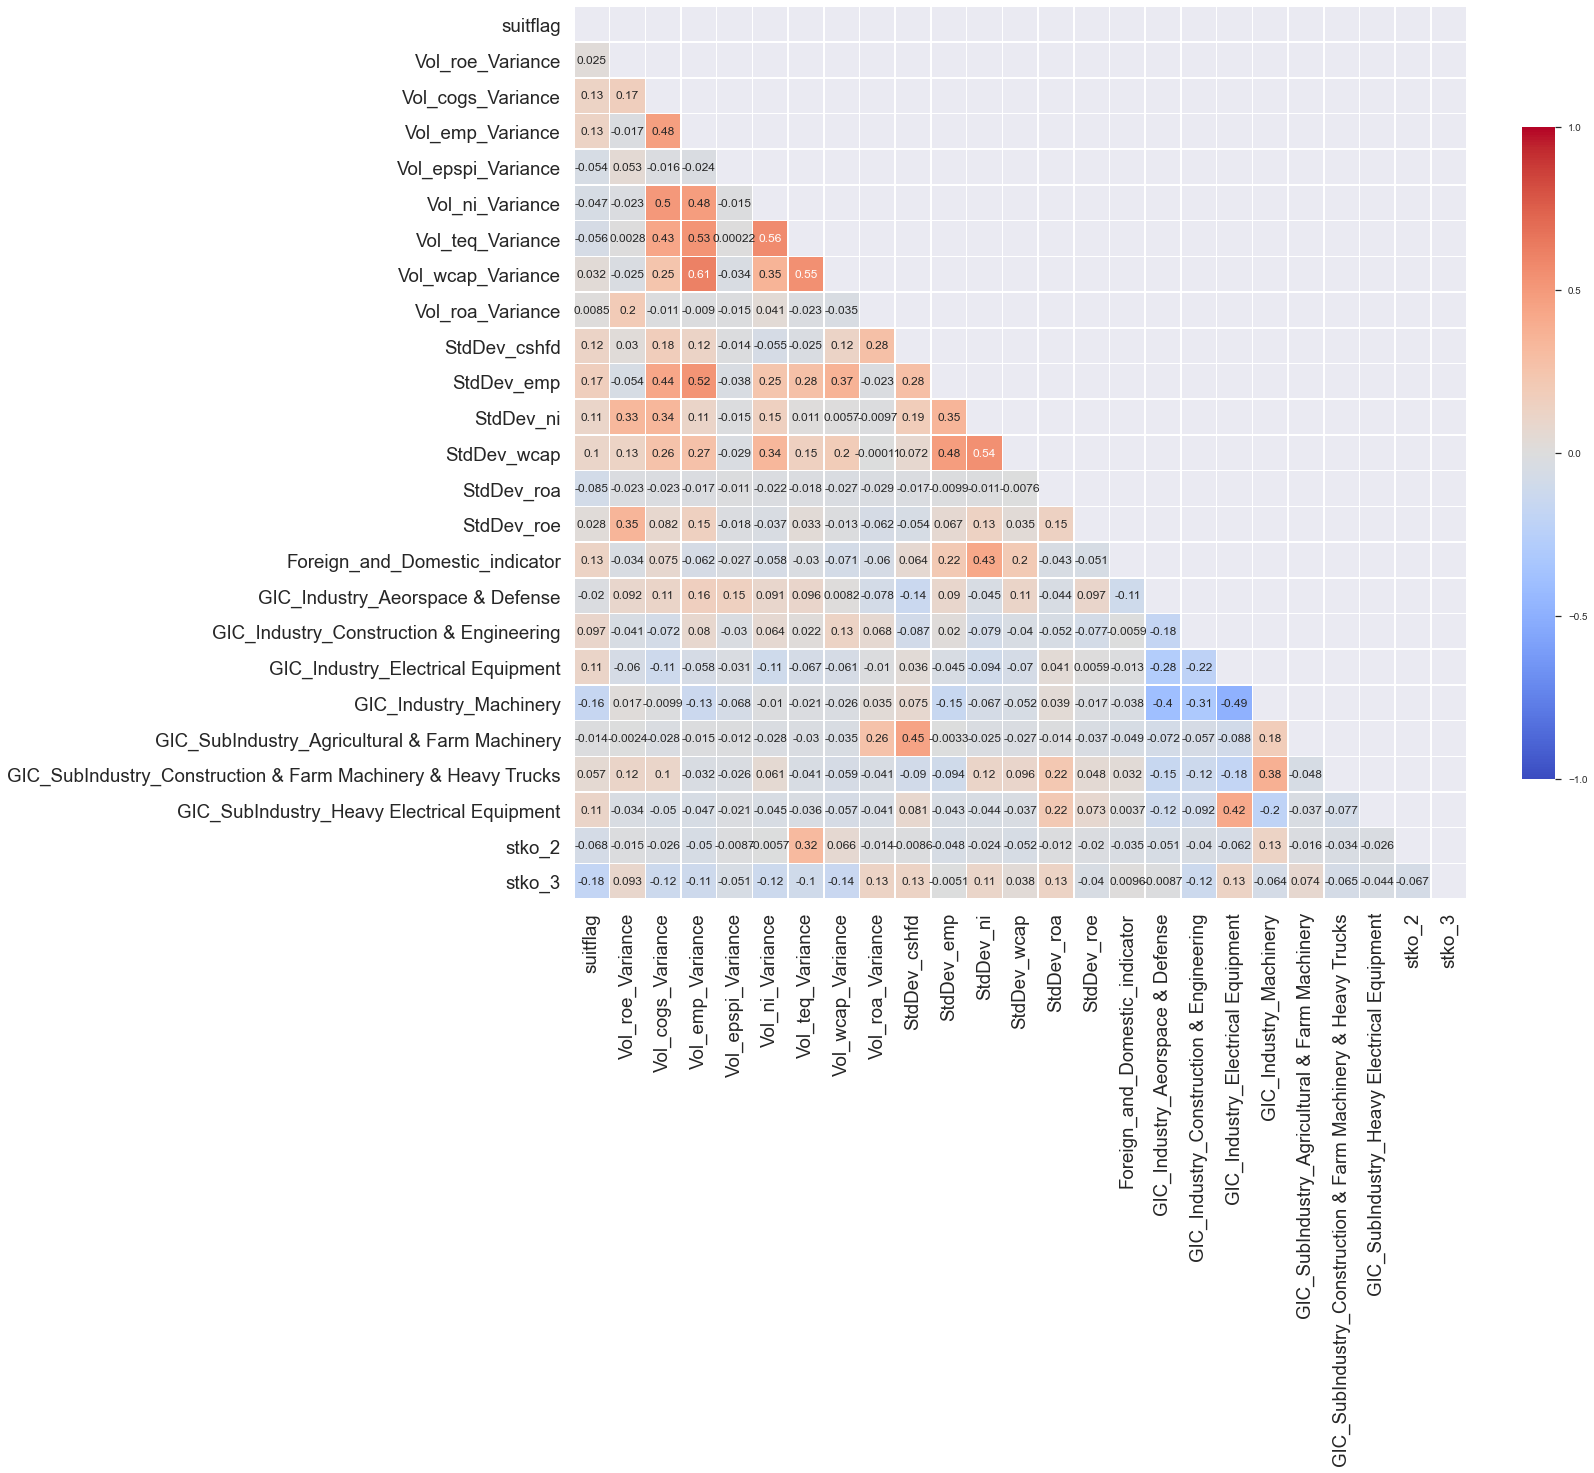

In [20]:
corr_matrix = df2.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale = .9)

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': 0.6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})


#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [21]:
#Check to ensure all values are numeric and convert all as necessary
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 10519 to 66446
Data columns (total 26 columns):
suitflag                                                        178 non-null float64
restatementflag                                                 178 non-null object
Vol_roe_Variance                                                178 non-null float64
Vol_cogs_Variance                                               178 non-null float64
Vol_emp_Variance                                                178 non-null float64
Vol_epspi_Variance                                              178 non-null float64
Vol_ni_Variance                                                 178 non-null float64
Vol_teq_Variance                                                178 non-null float64
Vol_wcap_Variance                                               178 non-null float64
Vol_roa_Variance                                                178 non-null float64
StdDev_cshfd                            

In [22]:
df2['restatementflag'] = df2['restatementflag'].astype(int)
df2['suitflag'] = df2['suitflag'].astype(int)

# drop restatment flag, as this was used in the prior steps when calculating restatement variances.
df2.drop(columns='restatementflag', inplace=True)

In [23]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df2.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,
StdDev_wcap,21
StdDev_emp,21
StdDev_roe,21
StdDev_roa,21
StdDev_cshfd,21
StdDev_ni,21


In [24]:
df2.fillna(0, inplace=True)

In [25]:
#Review the columns with null values in the dataset
nulls = pd.DataFrame(df2.isnull().sum().sort_values(ascending = False), columns=['Amount'])
nulls = nulls.loc[nulls['Amount'] > 0]
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls = pd.DataFrame(nulls.loc[nulls['Amount'] > 0])
# print('Shape of train dataset:', train.shape, '\nMissing values for train dataset below:\n', nulls)
nulls.index.name='Columns With Missing Values'
nulls

,Amount
Columns With Missing Values,


In [26]:
df2.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
suitflag,178.00,0.29,0.46,0.00,0.00,0.00,1.00,1.00
Vol_roe_Variance,178.00,0.11,0.30,0.02,0.06,0.06,0.06,3.00
Vol_cogs_Variance,178.00,0.23,0.40,0.03,0.16,0.16,0.16,3.00
Vol_emp_Variance,178.00,0.43,0.53,0.00,0.29,0.35,0.36,3.00
Vol_epspi_Variance,178.00,0.09,0.22,0.05,0.07,0.07,0.07,3.00
Vol_ni_Variance,178.00,0.23,0.47,0.04,0.14,0.14,0.14,3.00
Vol_teq_Variance,178.00,0.14,0.29,0.00,0.09,0.09,0.09,3.00
Vol_wcap_Variance,178.00,0.27,0.52,0.00,0.14,0.14,0.14,3.00
Vol_roa_Variance,178.00,0.13,0.40,0.02,0.06,0.06,0.06,3.00
StdDev_cshfd,178.00,0.34,0.45,0.00,0.19,0.31,0.35,3.00


## Split the Dataset

In [27]:
x = df2.drop(columns=['suitflag'])

y = df2[['suitflag']] 

In [28]:
# 0.42 test_size has pulled best results so far
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                   test_size=0.42,
                                                   random_state=16,
                                                   stratify=y)

print('X_train shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)

X_train shape:  (103, 24)
y_train.shape:  (103, 1)
X_test.shape:  (75, 24)


## Model

First model with decent results:

'suitflag', 'Vol_roe_Variance', 'Vol_cogs_Variance', 'Vol_emp_Variance', 'Vol_epspi_Variance', 'Vol_ni_Variance', 'Vol_teq_Variance', 'Vol_wcap_Variance', 'Vol_roa_Variance', 'StdDev_cshfd', 'StdDev_emp', 'StdDev_ni', 'StdDev_wcap', 'StdDev_roa', 'StdDev_roe', 'Foreign_and_Domestic_indicator', 'GIC_Industry_Aeorspace & Defense', 'GIC_Industry_Construction & Engineering', 'GIC_Industry_Electrical Equipment', 'GIC_Industry_Machinery', 'GIC_SubIndustry_Agricultural & Farm Machinery', 'GIC_SubIndustry_Construction & Farm Machinery & Heavy Trucks', 'GIC_SubIndustry_Heavy Electrical Equipment', 'stko_2', 'stko_3'

In [29]:
df2.columns

Index(['suitflag', 'Vol_roe_Variance', 'Vol_cogs_Variance', 'Vol_emp_Variance', 'Vol_epspi_Variance', 'Vol_ni_Variance', 'Vol_teq_Variance', 'Vol_wcap_Variance', 'Vol_roa_Variance', 'StdDev_cshfd', 'StdDev_emp', 'StdDev_ni', 'StdDev_wcap', 'StdDev_roa', 'StdDev_roe', 'Foreign_and_Domestic_indicator', 'GIC_Industry_Aeorspace & Defense', 'GIC_Industry_Construction & Engineering', 'GIC_Industry_Electrical Equipment', 'GIC_Industry_Machinery', 'GIC_SubIndustry_Agricultural & Farm Machinery', 'GIC_SubIndustry_Construction & Farm Machinery & Heavy Trucks', 'GIC_SubIndustry_Heavy Electrical Equipment', 'stko_2', 'stko_3'], dtype='object')

In [30]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), 
               family = sm.families.Binomial())
print(logm1.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               suitflag   No. Observations:                  103
Model:                            GLM   Df Residuals:                       79
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38.034
Date:                Thu, 14 Oct 2021   Deviance:                       76.068
Time:                        23:37:25   Pearson chi2:                     123.
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [31]:
'Vol_roe_Variance', 'StdDev_emp', 'StdDev_roa', 'GIC_SubIndustry_Heavy Electrical Equipment', 'stko_3'

('Vol_roe_Variance',
 'StdDev_emp',
 'StdDev_roa',
 'GIC_SubIndustry_Heavy Electrical Equipment',
 'stko_3')

In [32]:
logistic_regression1 = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression1.fit(X_train, y_train)

acc_logistic_regression1 = round(logistic_regression1.score(X_test, y_test) * 100, 2)
prec_logistic_regression1 = round(precision_score(y_pred=logistic_regression1.predict(X_test), y_true=y_test)* 100, 2)
recall_logistic_regression1 = round(recall_score(y_pred=logistic_regression1.predict(X_test), y_true=y_test)* 100, 2)
f1_logistic_regression1 = round(f1_score(y_pred=logistic_regression1.predict(X_test), y_true=y_test)* 100, 2)

print_score(logistic_regression1, X_train, y_train, X_test, y_test, train=True)
print_score(logistic_regression1, X_train, y_train, X_test, y_test, train=False)

res_1 = cross_val_score(logistic_regression1, X_train, y_train, scoring = 'accuracy', cv = 10)

Train Result:

Initial Accuracy Score:  0.7864
 ----------------------------------------
Test Result:

Confusion Matrix: 
 [[47  6]
 [20  2]]

Initial Accuracy Score:  0.6533


## Confusion Matrix

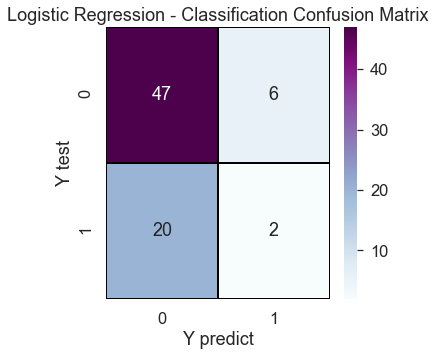

In [33]:
# The confusion matrix
sns.set(font_scale = 1.5)
logistic_regression_cm = confusion_matrix(y_test, 
                                          logistic_regression1.predict(X_test))
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(logistic_regression_cm, 
            annot=True, 
            linewidth=0.7, 
            linecolor='black', 
            fmt='g', 
            ax=ax, 
            cmap="BuPu")
plt.title('Logistic Regression - Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

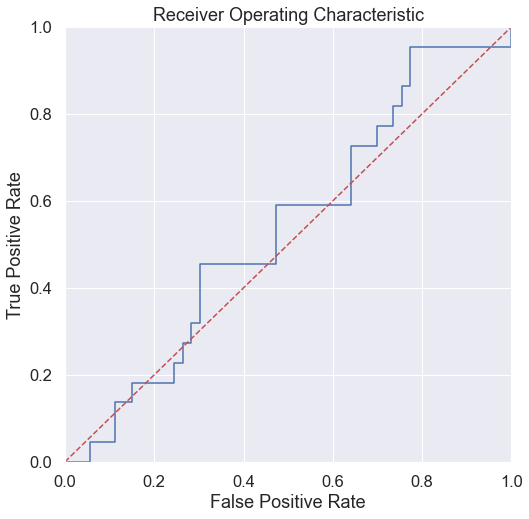

In [34]:
probs = logistic_regression1.predict_proba(X_test)
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<b>Review: </b>There are a total of  variables that are significant. Below are the variables to select when re-running the model:

    Vol_roe_Variance
    StdDev_emp
    StdDev_roa
    GIC_SubIndustry_Heavy Electrical Equipment
    stko_3t


# Logistic Regression - Second Run

In [35]:
sig_variables = ['suitflag', 'Vol_roe_Variance', 'StdDev_emp', 'StdDev_roa', 'GIC_SubIndustry_Heavy Electrical Equipment', 'stko_3']
df3 = df2[sig_variables]

## Review Data Correlations

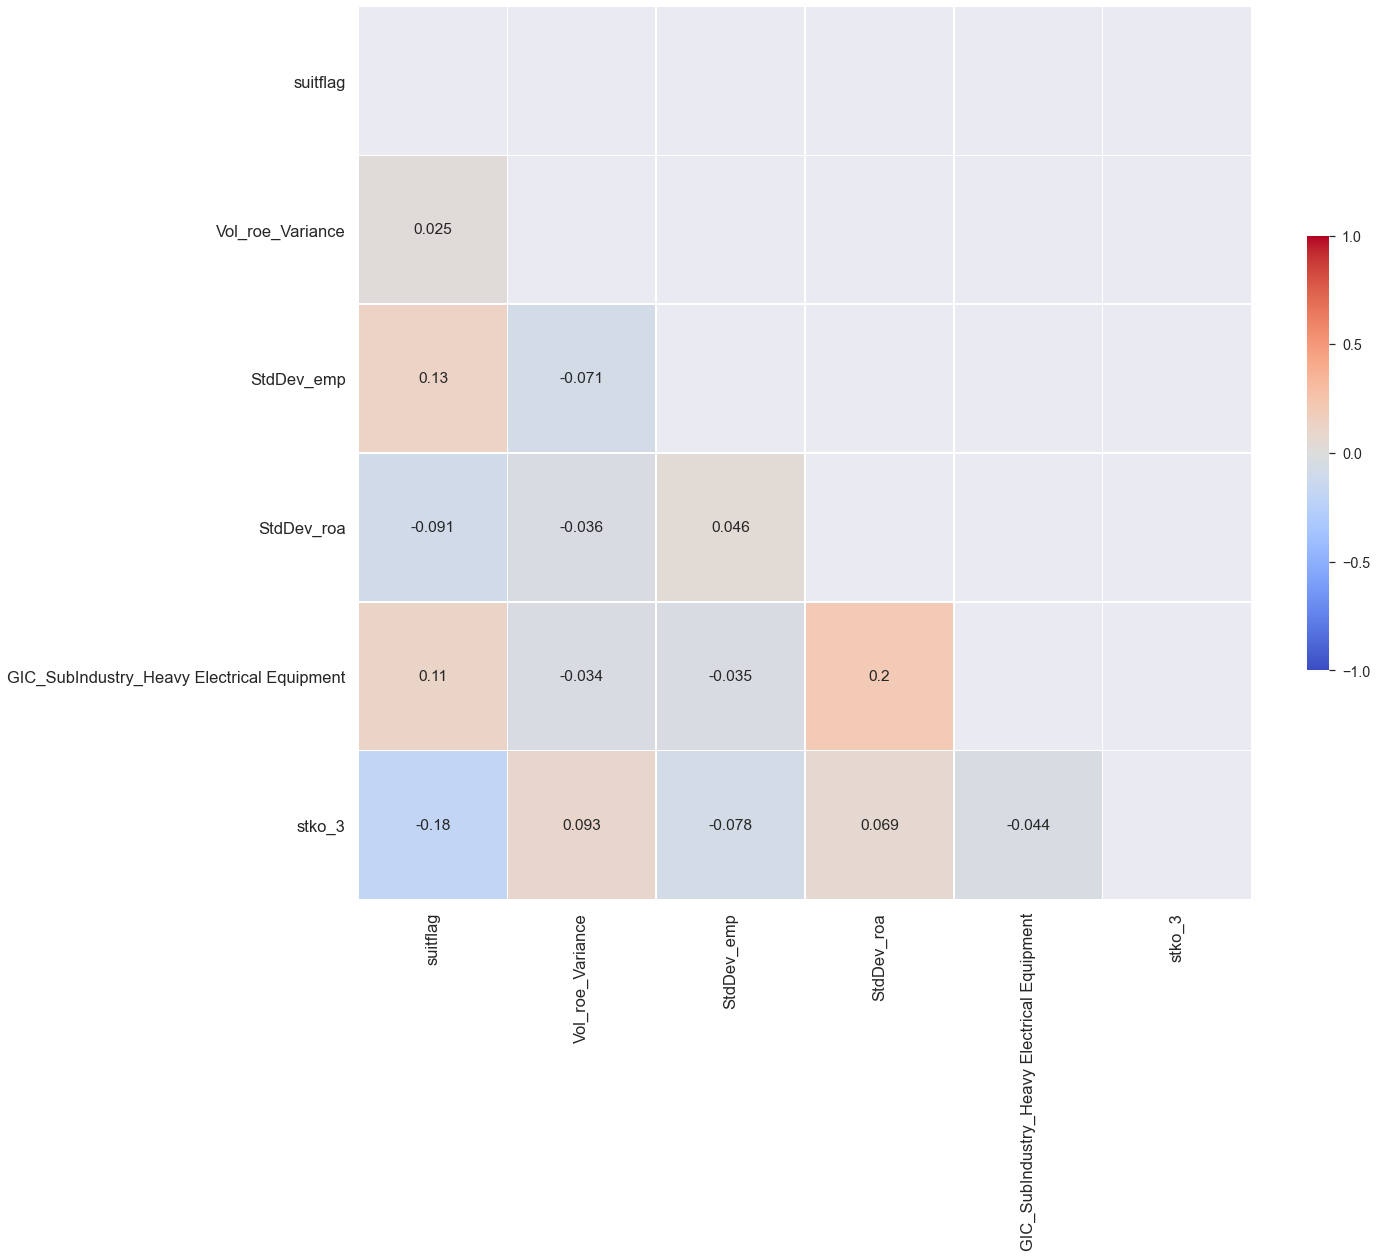

In [36]:
corr_matrix = df3.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale = 1.3)

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True)


#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [37]:
# Output any correlated values over 0.65 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.65:
            print(index,value)
            
high_corr_and_check(df3)

<b>Action: </b>There are no highly correlated variables I believe would help the analysis to remove.

In [38]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 10519 to 66446
Data columns (total 6 columns):
suitflag                                      178 non-null int32
Vol_roe_Variance                              178 non-null float64
StdDev_emp                                    178 non-null float64
StdDev_roa                                    178 non-null float64
GIC_SubIndustry_Heavy Electrical Equipment    178 non-null uint8
stko_3                                        178 non-null uint8
dtypes: float64(3), int32(1), uint8(2)
memory usage: 11.6 KB


## Split the Dataset

In [39]:
x = df3.drop(columns='suitflag')

y = df3[['suitflag']] 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                   test_size=0.55,
                                                   random_state=16,
                                                   stratify=y)

print('X_train shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)

X_train shape:  (80, 5)
y_train.shape:  (80, 1)
X_test.shape:  (98, 5)


## Model

In [41]:
# Logistic regression model
logm2 = sm.GLM(y_train,(sm.add_constant(X_train)), 
               family = sm.families.Binomial())
print(logm2.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               suitflag   No. Observations:                   80
Model:                            GLM   Df Residuals:                       74
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38.004
Date:                Thu, 14 Oct 2021   Deviance:                       76.008
Time:                        23:37:34   Pearson chi2:                     84.5
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [42]:
logistic_regression2 = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression2.fit(X_train, y_train)

acc_logistic_regression2 = round(logistic_regression2.score(X_test, y_test) * 100, 2)
prec_logistic_regression2 = round(precision_score(y_pred=logistic_regression2.predict(X_test), y_true=y_test)* 100, 2)
recall_logistic_regression2 = round(recall_score(y_pred=logistic_regression2.predict(X_test), y_true=y_test)* 100, 2)
f1_logistic_regression2 = round(f1_score(y_pred=logistic_regression2.predict(X_test), y_true=y_test)* 100, 2)

print_score(logistic_regression2, X_train, y_train, X_test, y_test, train=True)
print_score(logistic_regression2, X_train, y_train, X_test, y_test, train=False)

res_2 = cross_val_score(logistic_regression2, X_train, y_train, scoring = 'accuracy', cv = 10)

Train Result:

Initial Accuracy Score:  0.7375
 ----------------------------------------
Test Result:

Confusion Matrix: 
 [[68  1]
 [27  2]]

Initial Accuracy Score:  0.7143


## Confusion Matrix

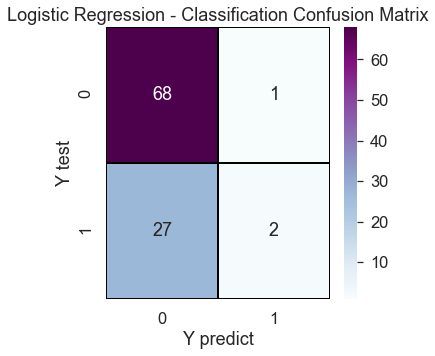

In [43]:
# The confusion matrix
sns.set(font_scale = 1.5)
logistic_regression_cm = confusion_matrix(y_test, 
                                          logistic_regression2.predict(X_test))
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(logistic_regression_cm, 
            annot=True, 
            linewidth=0.7, 
            linecolor='black', 
            fmt='g', 
            ax=ax, 
            cmap="BuPu")
plt.title('Logistic Regression - Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

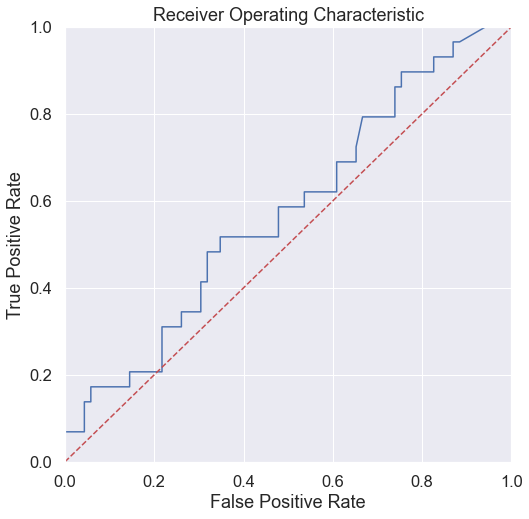

In [44]:
probs = logistic_regression2.predict_proba(X_test)
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<b>Review: </b>After a second model run, I am going to drop the following columns and re-run:

1) Vol_roe_Variance
2) GIC_SubIndustry_Heavy

# Logistic Regression - Third Run

In [45]:
df4 = df3.drop(columns=['Vol_roe_Variance',
                        'GIC_SubIndustry_Heavy Electrical Equipment'])

## Review Data Correlations

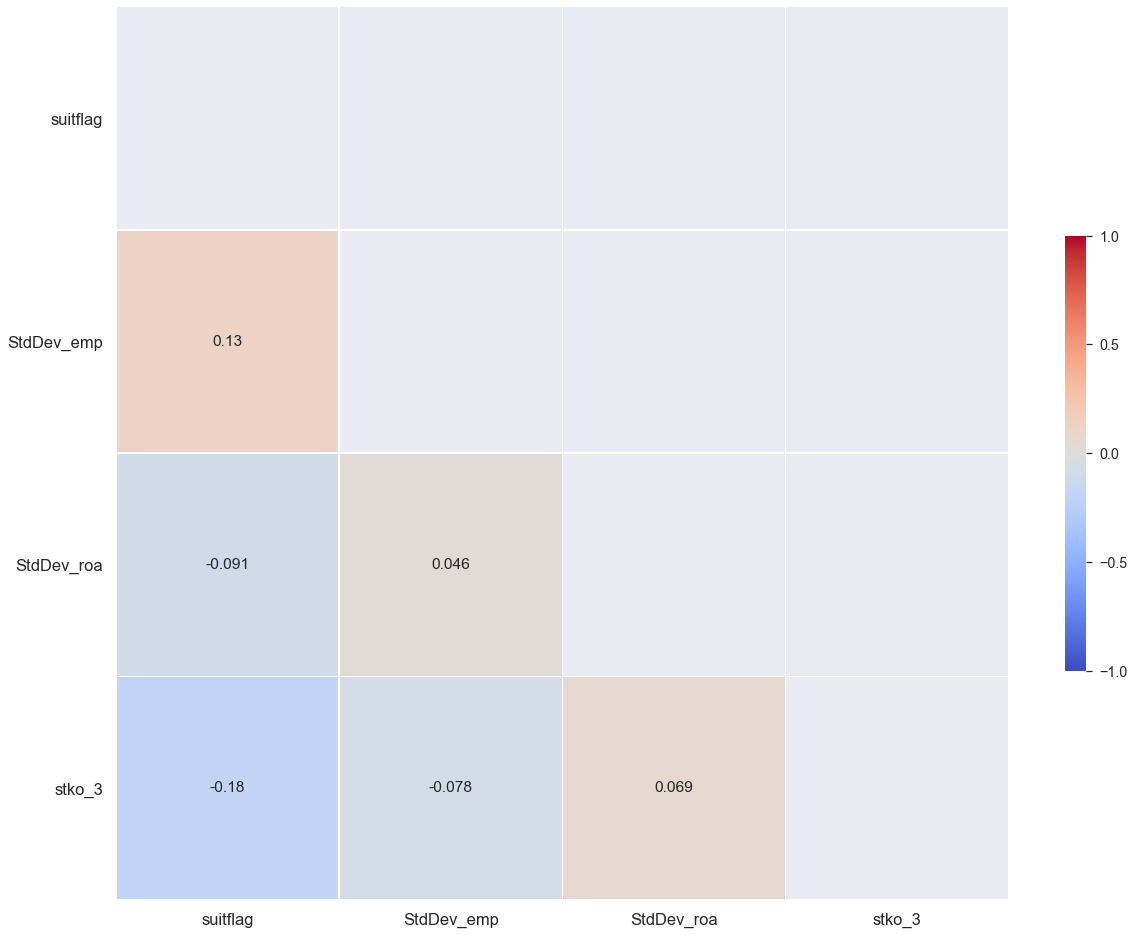

In [46]:
corr_matrix = df4.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale = 1.3)

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True)


#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [47]:
# Output any correlated values over 0.65 - isolating high-correlated variables to remove from the analysis
def high_corr_and_check(X):
    corr_matrix = X.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), 
                                     k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    for index, value in sol.items():
        if value > 0.65:
            print(index,value)
            
high_corr_and_check(df4)

<b>Action: </b>There are no highly correlated variables I believe would help the analysis to remove.

In [48]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 10519 to 66446
Data columns (total 4 columns):
suitflag      178 non-null int32
StdDev_emp    178 non-null float64
StdDev_roa    178 non-null float64
stko_3        178 non-null uint8
dtypes: float64(2), int32(1), uint8(1)
memory usage: 10.0 KB


## Split the Dataset

In [49]:
x = df4.drop(columns='suitflag')

y = df4[['suitflag']] 

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                   test_size=0.48,
                                                   random_state=16,
                                                   stratify=y)

print('X_train shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)

X_train shape:  (92, 3)
y_train.shape:  (92, 1)
X_test.shape:  (86, 3)


## Model

In [51]:
# Logistic regression model
X_train_sm = sm.add_constant(X_train)

logm3 = sm.GLM(y_train,(sm.add_constant(X_train)), 
               family = sm.families.Binomial())
print(logm3.fit().summary())

res = logm3.fit()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               suitflag   No. Observations:                   92
Model:                            GLM   Df Residuals:                       88
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.031
Date:                Thu, 14 Oct 2021   Deviance:                       98.061
Time:                        23:37:35   Pearson chi2:                     101.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3204      0.654      0.490      0.6

In [52]:
logistic_regression3 = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression3.fit(X_train, y_train)

acc_logistic_regression3 = round(logistic_regression3.score(X_test, y_test) * 100, 2)
prec_logistic_regression3 = round(precision_score(y_pred=logistic_regression3.predict(X_test), y_true=y_test)* 100, 2)
recall_logistic_regression3 = round(recall_score(y_pred=logistic_regression3.predict(X_test), y_true=y_test)* 100, 2)
f1_logistic_regression3 = round(f1_score(y_pred=logistic_regression3.predict(X_test), y_true=y_test)* 100, 2)

print_score(logistic_regression3, X_train, y_train, X_test, y_test, train=True)
print_score(logistic_regression3, X_train, y_train, X_test, y_test, train=False)

res_3 = cross_val_score(logistic_regression3, X_train, y_train, scoring = 'accuracy', cv = 10)

Train Result:

Initial Accuracy Score:  0.7391
 ----------------------------------------
Test Result:

Confusion Matrix: 
 [[60  1]
 [24  1]]

Initial Accuracy Score:  0.7093


## Confusion Matrix

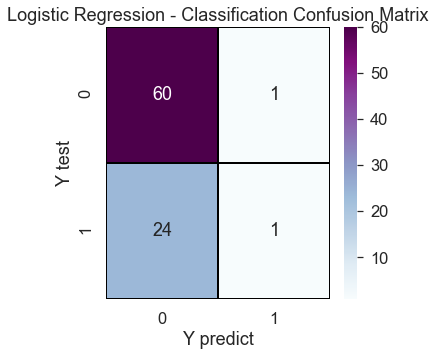

In [53]:
# The confusion matrix
sns.set(font_scale = 1.5)
logistic_regression_cm = confusion_matrix(y_test, 
                                          logistic_regression3.predict(X_test))
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(logistic_regression_cm, 
            annot=True, 
            linewidth=0.7, 
            linecolor='black', 
            fmt='g', 
            ax=ax, 
            cmap="BuPu")
plt.title('Logistic Regression - Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

<b>Review: </b>After a third model run, all variable remain significant and thus the analysis will conclude and the confusion matrix reviewed.

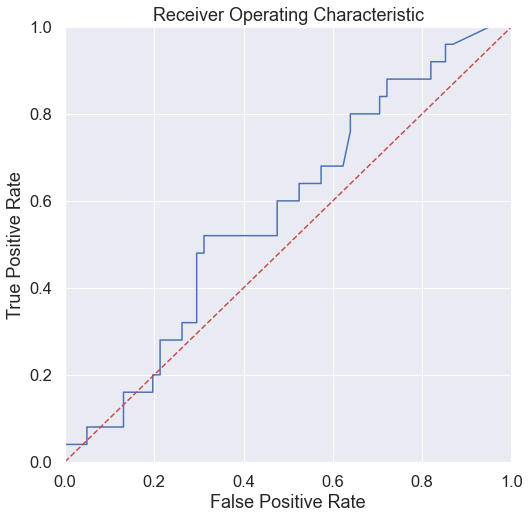

In [54]:
probs = logistic_regression3.predict_proba(X_test)
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model Evaluation

In [55]:
# Create a list which contains classifiers 
classifiers = []
classifiers.append(logistic_regression1)
classifiers.append(logistic_regression2)
classifiers.append(logistic_regression3)
print('Number of Classifiers: ',len(classifiers))

# Number of Cross Validations
cv = 10
print('Number of Cross Validations: ', cv, '\n','-'*40)

# Create a list which contains cross validation results for each classifier
cv_results = []
cv_results.append(res_1)
cv_results.append(res_2)
cv_results.append(res_3)

# for classifier in classifiers:
#     cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = 10))
    
# Mean and standard deviation of cross validation results for each classifier  
cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(round(cv_result.mean()*100,2))
    cv_std.append(round(cv_result.std(),3))

algos = ['Logistic Regression - Initial Run',
         'Logistic Regression - Second Run',
         'Logistic Regression - Third Run'
        ]

acc_scores = [acc_logistic_regression1,
              acc_logistic_regression2,
              acc_logistic_regression3
             ]

prec_scores = [prec_logistic_regression1,
               prec_logistic_regression2,
               prec_logistic_regression3
              ]

recall_scores = [recall_logistic_regression1,
                 recall_logistic_regression2,
                 recall_logistic_regression3
                ]

f1_scores = [f1_logistic_regression1,
             f1_logistic_regression2,
             f1_logistic_regression3
            ]

    
cv_res = pd.DataFrame({'Algorithm': algos,
                       'Initial Accuracy Scores': acc_scores,
                       'Cross Validation Mean': cv_mean, 
                       'Cross Validation Std': cv_std,
                       'Precision Score': prec_scores,
                       'Recall Scores': recall_scores,
                       'F1 Scores': f1_scores
                       })

cv_res.sort_values(by = 'F1 Scores', ascending = False).set_index('Algorithm')

Number of Classifiers:  3
Number of Cross Validations:  10 
 ----------------------------------------


,Initial Accuracy Scores,Cross Validation Mean,Cross Validation Std,Precision Score,Recall Scores,F1 Scores
Algorithm,,,,,,
Logistic Regression - Initial Run,65.33,67.00,0.06,25.00,9.09,13.33
Logistic Regression - Second Run,71.43,71.25,0.06,66.67,6.90,12.50
Logistic Regression - Third Run,70.93,69.56,0.07,50.00,4.00,7.41


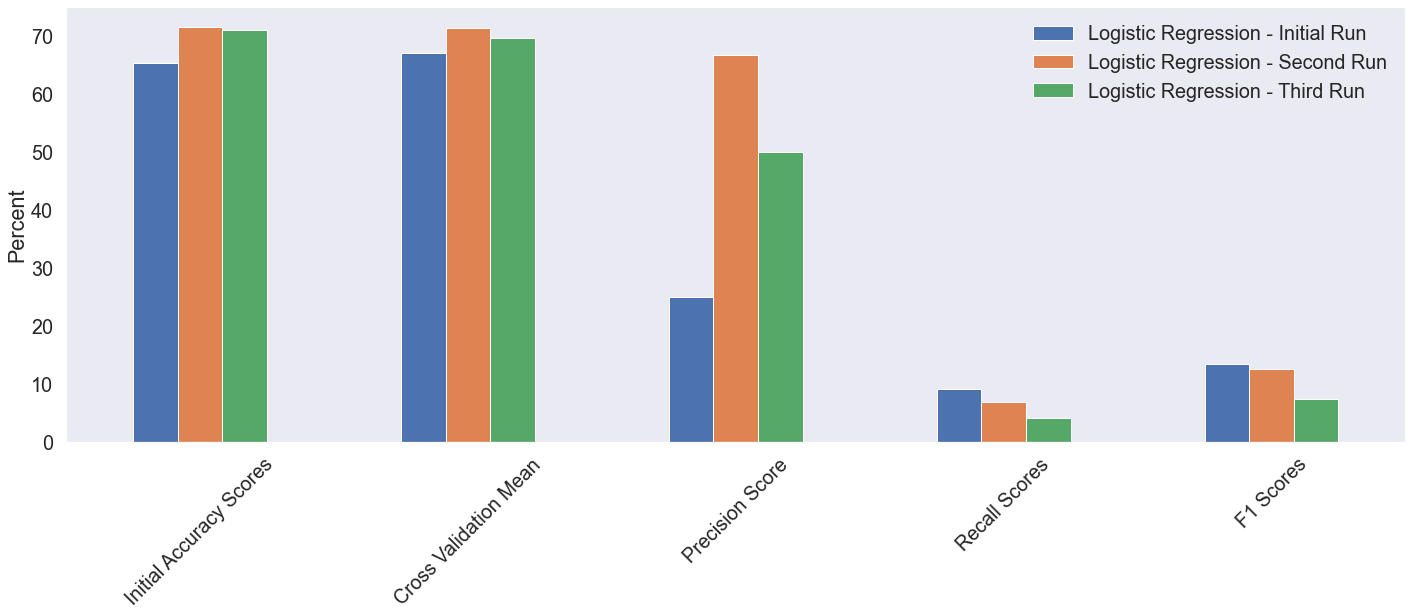

In [56]:
cv_res1 = cv_res.drop(columns='Cross Validation Std').set_index('Algorithm').T
sns.set(font_scale = 1.8)
fig, ax = plt.subplots(figsize=(24,8))
cv_res1.plot(kind='bar', ax=ax)
plt.xticks(rotation = 45)
plt.ylabel('Percent')
plt.legend(loc='top right')
ax.grid();

## Visualize F1 Scores to Identify the Best Model

Text(0.5, 1.0, 'F1 Scores')

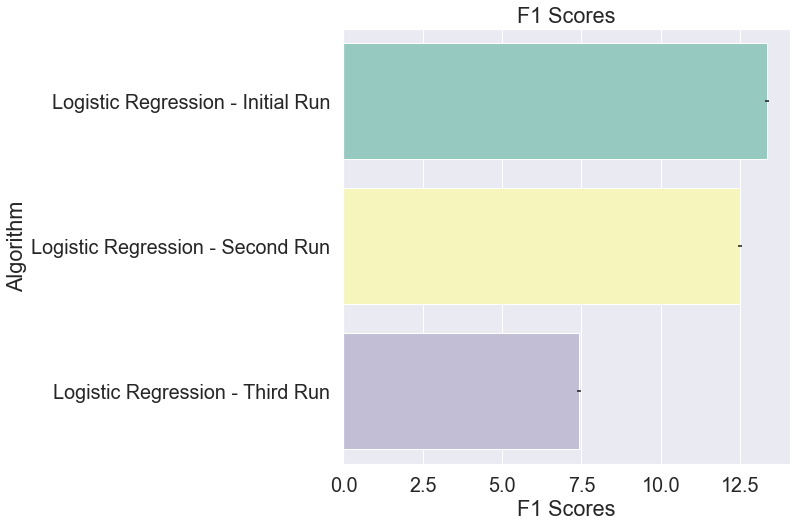

In [57]:
sns.barplot('F1 Scores', 
            'Algorithm', 
            data = cv_res, 
            order = cv_res.sort_values(by = 'F1 Scores', 
                                       ascending = False)['Algorithm'], 
            palette = 'Set3', 
            **{'xerr': cv_std})

plt.ylabel('Algorithm')
plt.title('F1 Scores')

## Receiver Operating Characteristic Curve

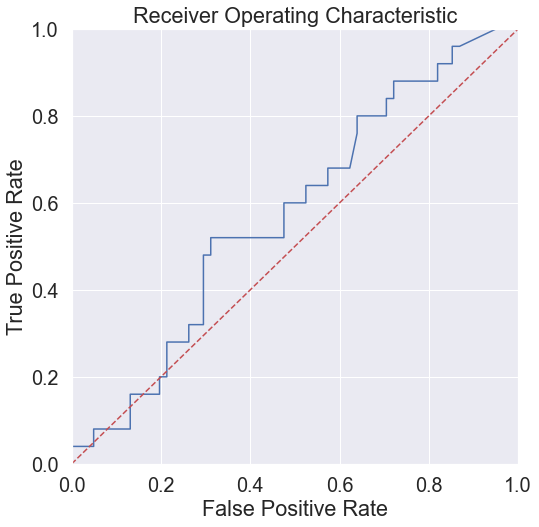

In [58]:
probs = logistic_regression3.predict_proba(X_test)
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Combine Prediction Results to Test Dataset

In [59]:
x

,StdDev_emp,StdDev_roa,stko_3
gvkey,,,
10519,0.26,0.12,0
10622,0.57,0.13,1
10735,0.81,0.12,0
110685,1.93,0.13,0
113530,0.37,0.08,0
...,...,...,...
8546,0.28,0.12,0
179405,0.00,0.00,1
65399,0.33,0.12,0


In [60]:
Y_pred = logistic_regression3.predict_proba(x)[:, 1]
Y_pred

array([0.32251293, 0.15656693, 0.3849506 , 0.52229527, 0.33742196,
       0.3038267 , 0.14765157, 0.31901822, 0.34016958, 0.33165254,
       0.33935686, 0.33475102, 0.14167317, 0.32154085, 0.33655269,
       0.3038267 , 0.30758599, 0.33898412, 0.14528232, 0.39034501,
       0.14555177, 0.34055793, 0.34070168, 0.14692341, 0.2996953 ,
       0.33623837, 0.3336681 , 0.3038267 , 0.46880154, 0.3038267 ,
       0.33393214, 0.3038267 , 0.33554564, 0.31409001, 0.14912205,
       0.30327601, 0.34132573, 0.3038267 , 0.12764836, 0.33915388,
       0.65056806, 0.58730387, 0.3038267 , 0.31276264, 0.3348034 ,
       0.33754033, 0.65051206, 0.34402915, 0.51343253, 0.34306441,
       0.32278043, 0.33065881, 0.32338137, 0.12685318, 0.33832847,
       0.16737173, 0.31145402, 0.56011017, 0.3038267 , 0.30250043,
       0.15231824, 0.12764836, 0.15198359, 0.33787166, 0.3195346 ,
       0.33578649, 0.34048371, 0.57072911, 0.29782399, 0.34483534,
       0.32769474, 0.34102302, 0.37417953, 0.32741855, 0.36298

In [61]:
df.reset_index(inplace=True)
df.reset_index(inplace=True)

In [62]:
df.set_index('gvkey', inplace=True)

In [63]:
print('The number of companies in this prediction is: ' ,len(Y_pred))

The number of companies in this prediction is:  178


In [64]:
submit = pd.DataFrame({'index': df['index'], 'suit_pred': Y_pred})
submit = submit[['suit_pred']]
submit

,suit_pred
gvkey,
10519,0.32
10622,0.16
10735,0.38
110685,0.52
113530,0.34
...,...
8546,0.32
179405,0.13
65399,0.33


In [65]:
df = df.join(submit)
df.drop(columns='index', inplace=True)
df

,GIC_Industry,GIC_SubIndustry,suitflag,stko,restatementflag,Vol_roe_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,STD_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,STD_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,Foreign_and_Domestic_indicator,suit_pred
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10519,Aeorspace & Defense,Aerospace & Defense,1.00,0,1,0.06,0.09,0.16,0.07,0.12,0.08,1.73,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.10,0.26,0.34,0.04,0.42,0.16,0.26,0.11,0.49,0.26,0.30,0.46,0.30,0.36,0.16,0.09,0.23,0.12,0.19,0,0.32
10622,Industrial Congolomerates,Industrial Conglomerates,1.00,3,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,1.07,2.38,3.00,0.53,0.23,3.00,0.57,0.00,2.52,2.61,3.00,1.12,0.70,1.51,0.28,0.02,3.00,0.13,0.19,1,0.16
10735,Machinery,Construction & Farm Machinery & Heavy Trucks,1.00,0,1,0.06,0.08,0.13,0.07,0.11,0.07,0.81,0.07,0.14,0.09,0.07,0.09,0.12,0.14,0.08,0.09,0.06,0.02,0.85,0.33,0.33,0.02,0.12,0.81,0.25,0.13,1.04,0.42,0.09,0.10,0.36,0.19,0.09,0.06,0.12,0.19,0,0.38
110685,Aeorspace & Defense,Aerospace & Defense,1.00,0,1,0.06,0.08,2.47,0.07,0.08,0.06,3.00,0.07,0.14,0.10,1.40,0.10,0.69,0.53,0.05,0.01,0.06,0.05,0.15,0.88,0.03,0.03,0.04,1.93,0.30,0.02,0.08,0.89,0.31,0.19,0.35,0.07,0.10,0.19,0.13,0.20,0,0.52
113530,Electrical Equipment,Electrical Components & Equipment,1.00,0,1,0.11,0.08,0.14,0.11,0.08,0.08,0.33,0.07,0.21,0.09,0.02,0.07,0.16,0.05,0.08,0.09,0.38,0.20,0.21,0.33,0.04,0.16,0.30,0.37,0.49,0.34,0.34,0.35,0.31,0.22,0.31,0.16,0.11,0.25,0.08,0.05,0,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,Industrial Congolomerates,Industrial Conglomerates,0.00,0,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.58,0.06,0.96,0.15,0.07,0.02,0.28,0.27,3.00,0.72,1.24,2.18,0.51,1.60,3.00,0.02,1.45,0.12,0.19,1,0.32
179405,Electrical Equipment,Electrical Components & Equipment,0.00,3,1,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.13
65399,Machinery,Construction & Farm Machinery & Heavy Trucks,0.00,0,1,0.06,0.09,0.14,0.09,0.08,0.09,0.53,0.07,0.14,0.09,0.06,0.09,0.16,0.14,0.08,0.09,0.06,0.16,0.09,0.11,0.16,0.13,0.24,0.33,0.29,0.23,0.28,0.06,0.24,0.17,0.18,0.08,0.10,0.20,0.12,0.19,0,0.33


In [66]:
df['suitflag']

gvkey
10519    1.00
10622    1.00
10735    1.00
110685   1.00
113530   1.00
         ... 
8546     0.00
179405   0.00
65399    0.00
166491   0.00
66446    0.00
Name: suitflag, Length: 178, dtype: float64

In [67]:
df['Prediction_Score'] = round(df['suit_pred']*100, -1)
pd.value_counts(df['Prediction_Score'], dropna=False)

30.00    108
10.00     45
40.00     11
20.00      5
50.00      4
60.00      3
70.00      2
Name: Prediction_Score, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA62B9CDA0>]],
      dtype=object)

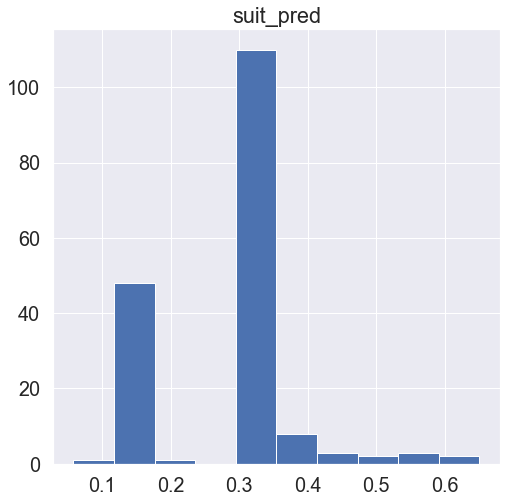

In [68]:
df.hist('suit_pred', bins=10)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

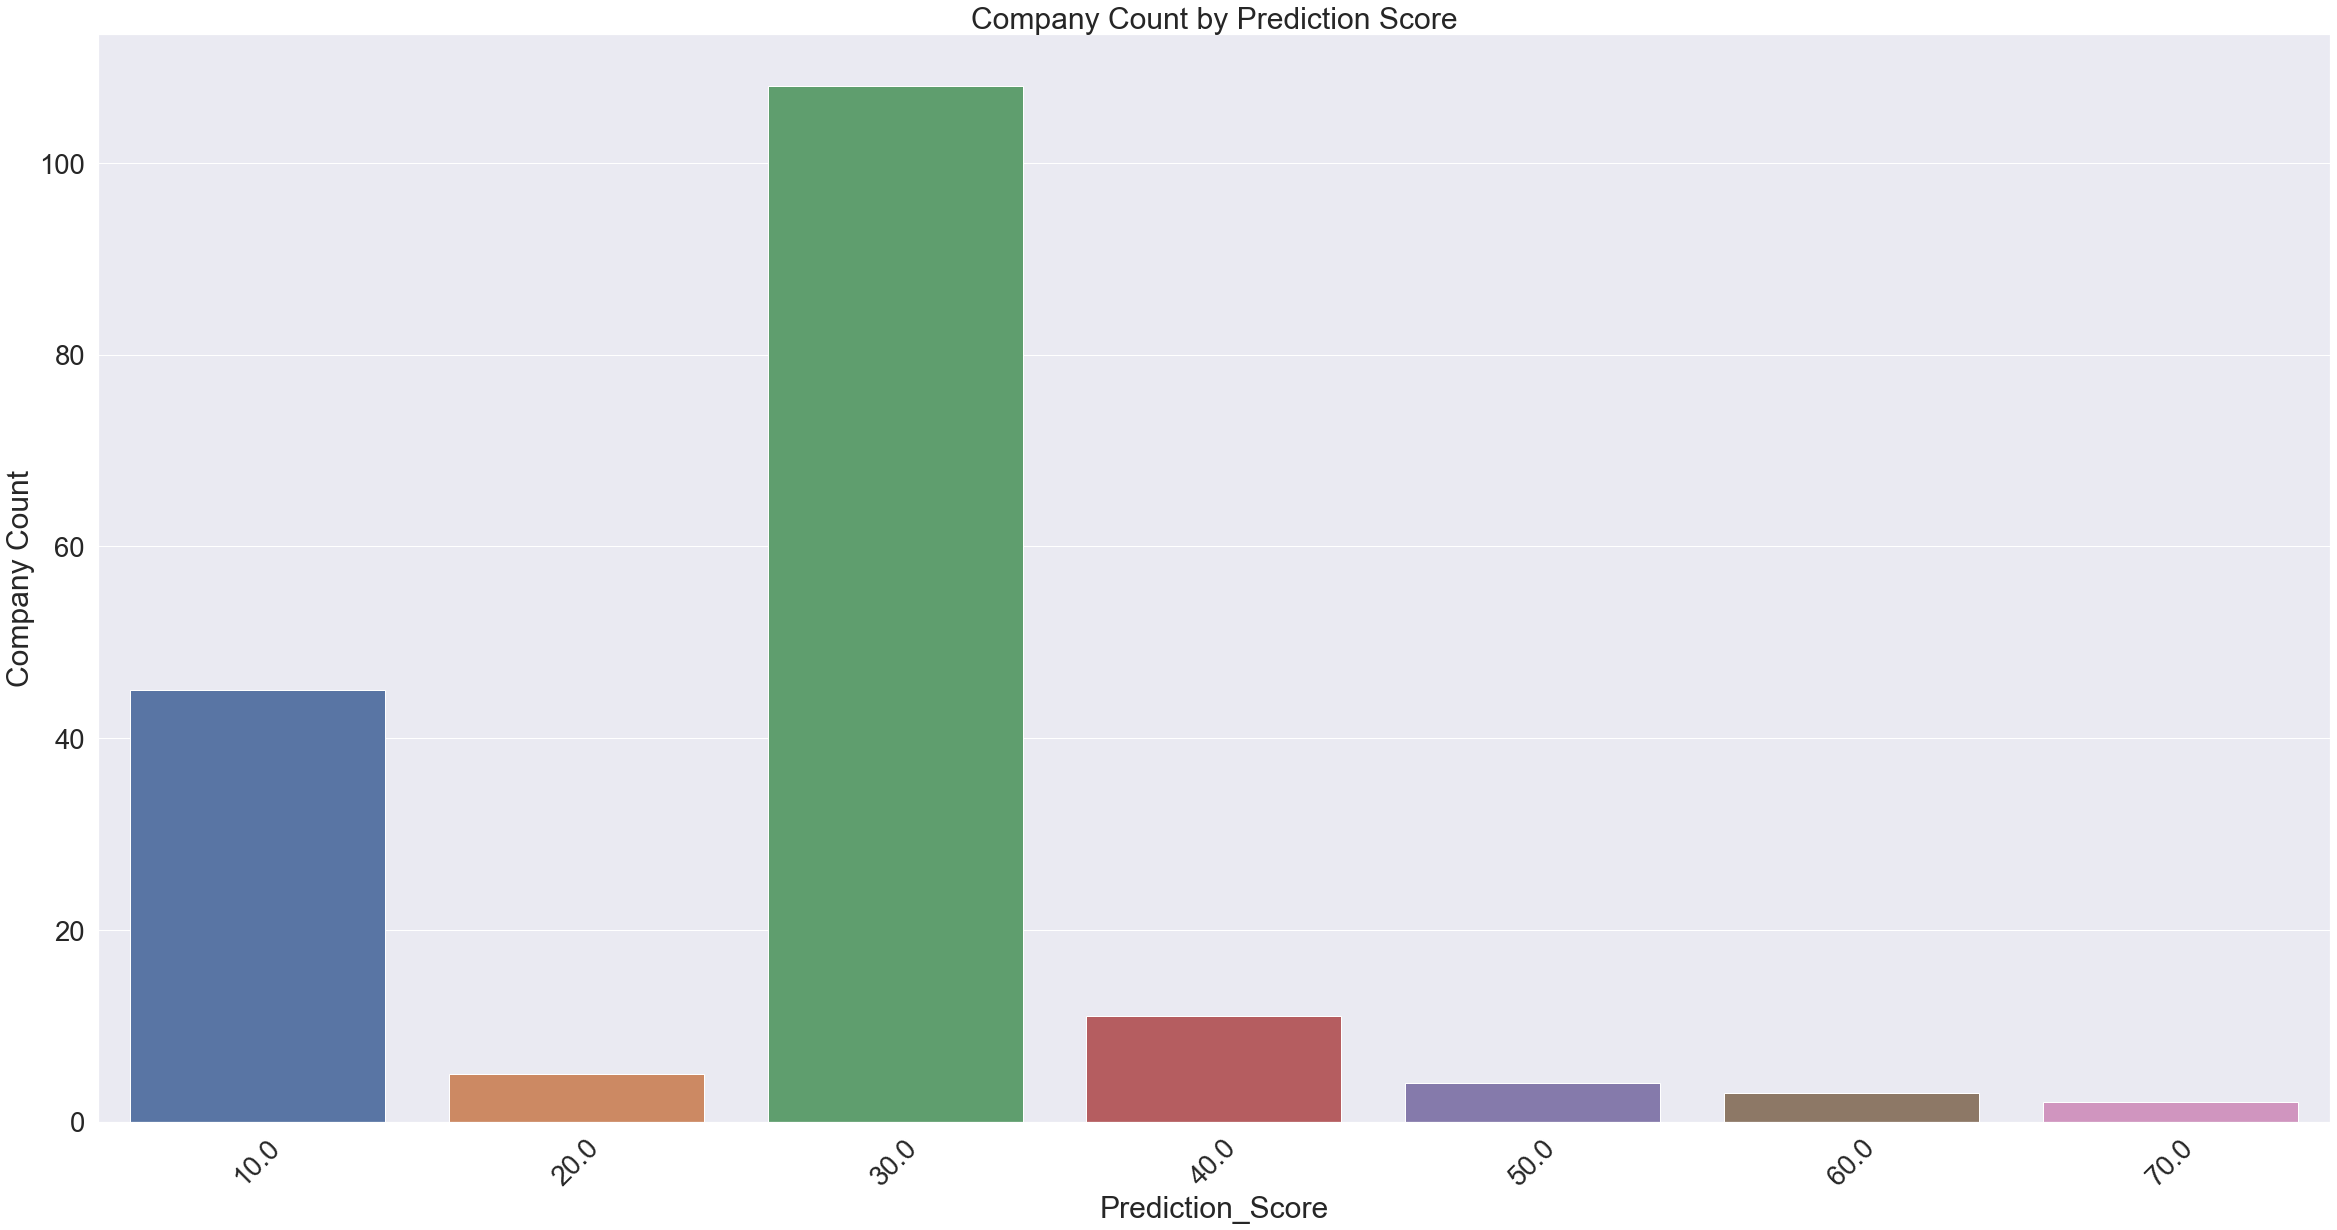

In [700]:
plt.figure(figsize = (40,20))
sns.set(font_scale = 2.5)


var = df['Prediction_Score']
sns.countplot(x = var,
            data = df)

plt.ylabel('Company Count')
plt.title('Company Count by Prediction Score')
plt.xticks(rotation = 45)
    

# Model Interpretation

In [703]:
model  = pd.DataFrame({"Features": X_train_sm.columns,"Coefficient":res.params.values})
model["Odds_Ratio"] = model["Coefficient"].apply(lambda x: np.exp(x))
model[["Coefficient","Odds_Ratio"]] = model[["Coefficient","Odds_Ratio"]].apply(lambda x: round(x,2))
model["Perc_Impact"] = model["Odds_Ratio"].apply(lambda x: (x-1)*100)
model = model.loc[model['Features']!='const'].sort_values(by='Odds_Ratio', ascending=False)
model

,Features,Coefficient,Odds_Ratio,Perc_Impact
1,StdDev_emp,0.90,2.45,145.00
3,stko_3,-1.85,0.16,-84.00
2,StdDev_roa,-12.84,0.00,-100.00


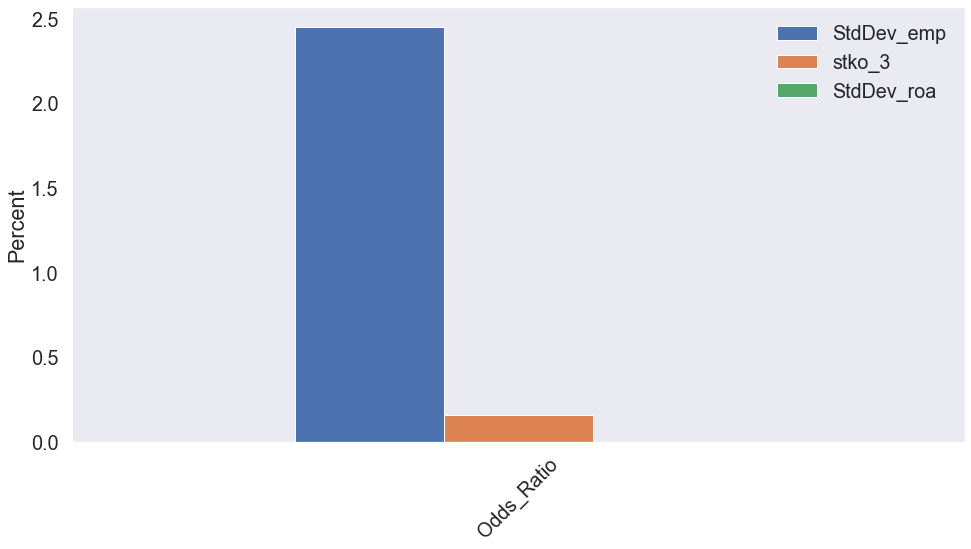

In [705]:
model_int = model.drop(columns=['Perc_Impact', 'Coefficient']).set_index('Features').T
model_int= model_int[['StdDev_emp', 'stko_3', 'StdDev_roa']]

sns.set(font_scale = 1.8)
fig, ax = plt.subplots(figsize=(16,8))
model_int.plot(kind='bar', ax=ax)
plt.xticks(rotation = 45)
plt.ylabel('Percent')
plt.legend(loc='top right')
ax.grid();

In [706]:
df

,GIC_Industry,GIC_SubIndustry,suitflag,stko,restatementflag,Vol_roe_Variance,Vol_capx_Variance,Vol_cogs_Variance,Vol_cshfd_Variance,Vol_dltt_Variance,Vol_dp_Variance,Vol_emp_Variance,Vol_epspi_Variance,Vol_ni_Variance,Vol_ppent_Variance,Vol_sale_Variance,Vol_teq_Variance,Vol_txt_Variance,Vol_wcap_Variance,Vol_xint_Variance,Vol_xsga_Variance,Vol_roa_Variance,STD_at,StdDev_capx,StdDev_cogs,StdDev_cshfd,StdDev_dltt,StdDev_dp,StdDev_emp,StdDev_epspi,StdDev_ni,StdDev_ppent,StdDev_sale,StdDev_teq,StdDev_txt,StdDev_wcap,STD_xido,StdDev_xint,StdDev_xsga,StdDev_roa,StdDev_roe,Foreign_and_Domestic_indicator,suit_pred,Prediction_Score
gvkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10519,Aeorspace & Defense,Aerospace & Defense,1.00,0,1,0.06,0.09,0.16,0.07,0.12,0.08,1.73,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.10,0.26,0.34,0.04,0.42,0.16,0.26,0.11,0.49,0.26,0.30,0.46,0.30,0.36,0.16,0.09,0.23,0.12,0.19,0,0.32,30.00
10622,Industrial Congolomerates,Industrial Conglomerates,1.00,3,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,1.07,2.38,3.00,0.53,0.23,3.00,0.57,0.00,2.52,2.61,3.00,1.12,0.70,1.51,0.28,0.02,3.00,0.13,0.19,1,0.16,20.00
10735,Machinery,Construction & Farm Machinery & Heavy Trucks,1.00,0,1,0.06,0.08,0.13,0.07,0.11,0.07,0.81,0.07,0.14,0.09,0.07,0.09,0.12,0.14,0.08,0.09,0.06,0.02,0.85,0.33,0.33,0.02,0.12,0.81,0.25,0.13,1.04,0.42,0.09,0.10,0.36,0.19,0.09,0.06,0.12,0.19,0,0.38,40.00
110685,Aeorspace & Defense,Aerospace & Defense,1.00,0,1,0.06,0.08,2.47,0.07,0.08,0.06,3.00,0.07,0.14,0.10,1.40,0.10,0.69,0.53,0.05,0.01,0.06,0.05,0.15,0.88,0.03,0.03,0.04,1.93,0.30,0.02,0.08,0.89,0.31,0.19,0.35,0.07,0.10,0.19,0.13,0.20,0,0.52,50.00
113530,Electrical Equipment,Electrical Components & Equipment,1.00,0,1,0.11,0.08,0.14,0.11,0.08,0.08,0.33,0.07,0.21,0.09,0.02,0.07,0.16,0.05,0.08,0.09,0.38,0.20,0.21,0.33,0.04,0.16,0.30,0.37,0.49,0.34,0.34,0.35,0.31,0.22,0.31,0.16,0.11,0.25,0.08,0.05,0,0.34,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,Industrial Congolomerates,Industrial Conglomerates,0.00,0,0,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,0.58,0.06,0.96,0.15,0.07,0.02,0.28,0.27,3.00,0.72,1.24,2.18,0.51,1.60,3.00,0.02,1.45,0.12,0.19,1,0.32,30.00
179405,Electrical Equipment,Electrical Components & Equipment,0.00,3,1,0.06,0.09,0.16,0.07,0.08,0.08,0.36,0.07,0.14,0.09,0.10,0.09,0.16,0.14,0.08,0.09,0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.13,10.00
65399,Machinery,Construction & Farm Machinery & Heavy Trucks,0.00,0,1,0.06,0.09,0.14,0.09,0.08,0.09,0.53,0.07,0.14,0.09,0.06,0.09,0.16,0.14,0.08,0.09,0.06,0.16,0.09,0.11,0.16,0.13,0.24,0.33,0.29,0.23,0.28,0.06,0.24,0.17,0.18,0.08,0.10,0.20,0.12,0.19,0,0.33,30.00


In [707]:
# df.to_csv('../01_data/03_final/suit_prediction.csv')

# END